In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2025-01-03 04:08:59.645783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 04:08:59.645849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 04:08:59.645882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 04:08:59.653770: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.3 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
dask-cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
numba 0.57.1+1.gb7ee25572 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [4]:
train_df = pd.read_csv('../newKDDTrain+.txt', header=None)

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
train_df.columns = columns

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
test_df = pd.read_csv('../newKDDTest+.txt', header=None)

test_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
test_df.columns = columns

test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [6]:
df = pd.concat([train_df, test_df])

In [7]:
df['class']

0         normal
1         normal
2        anomaly
3         normal
4         normal
          ...   
22539     normal
22540     normal
22541    anomaly
22542     normal
22543    anomaly
Name: class, Length: 148517, dtype: object

In [8]:
df.isnull().values.any()

False

In [9]:
len(df.columns)

42

In [10]:
df.shape

(148517, 42)

In [11]:
# 'label' 열의 값이 'normal.'이면 0으로, 'normal.'이 아니면 1로 변경
df['class'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)

# 변경된 데이터프레임 확인
print(df.head())

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   


In [12]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 적용
label_encoder = LabelEncoder()
df['protocol_type'] = label_encoder.fit_transform(df['protocol_type'])
df['service'] = label_encoder.fit_transform(df['service'])
df['flag'] = label_encoder.fit_transform(df['flag'])

# 인코딩된 데이터프레임 확인
print(df.head())

   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       20     9        491          0     0   
1         0              2       44     9        146          0     0   
2         0              1       49     5          0          0     0   
3         0              1       24     9        232       8153     0   
4         0              1       24     9        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.

In [13]:
df.shape

(148517, 42)

누적 분산 비율 (cumulative explained variance):
[0.18919362 0.317851   0.38738707 0.43961021 0.4865     0.52882691
 0.5676753  0.60102599 0.62934356 0.65603097 0.68175274 0.70731433
 0.73231683 0.75726586 0.78210081 0.80684803 0.83054577 0.85362758
 0.87282535 0.89117939 0.90691815 0.92178925 0.93424173 0.94577629
 0.95626197 0.96566752]
Label 데이터 타입: int64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


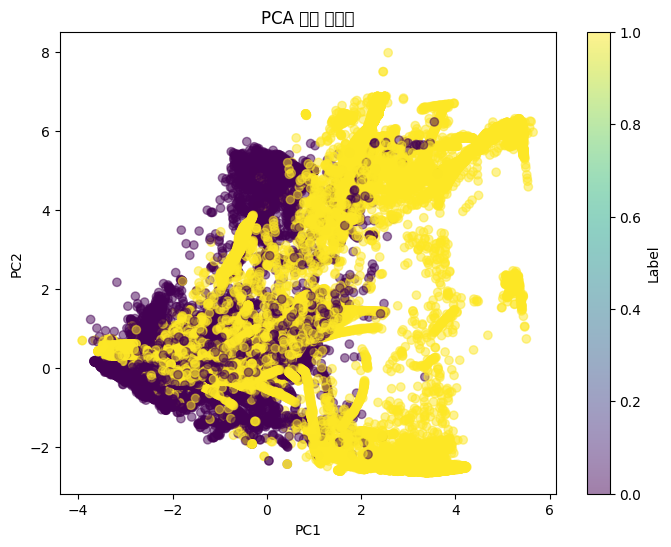

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

tmp = df.drop(labels = 'class',axis=1)
labels = df['class']

# 1. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tmp)

# 2. PCA 적용 (주성분 개수 설정)
n_components = 26  # 원하는 차원 수로 설정
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


# 3. PCA 누적 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
print("누적 분산 비율 (cumulative explained variance):")
print(explained_variance_ratio)

# 4. PCA 결과를 DataFrame으로 변환하고 label 병합
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_merged = X_pca_df.assign(label=labels.values)

# 열 이름 변경 (label -> class)
df_merged.rename(columns={'label': 'class'}, inplace=True)


# 5. 병합된 데이터 타입 확인
print("Label 데이터 타입:", df_merged['class'].dtype)

# 6. 정렬 여부 확인 (필요하면 추가)
# 확인 예시: 병합 전후 `labels` 순서와 `df_merged['label']`이 동일한지 점검
assert np.array_equal(labels.values, df_merged['class'].values), "Label 순서가 일치하지 않습니다."

# 7. PCA 결과 시각화 (2D로 줄인 경우)
import matplotlib.pyplot as plt
if n_components >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA 결과 시각화')
    plt.colorbar(label='Label')
    plt.show()

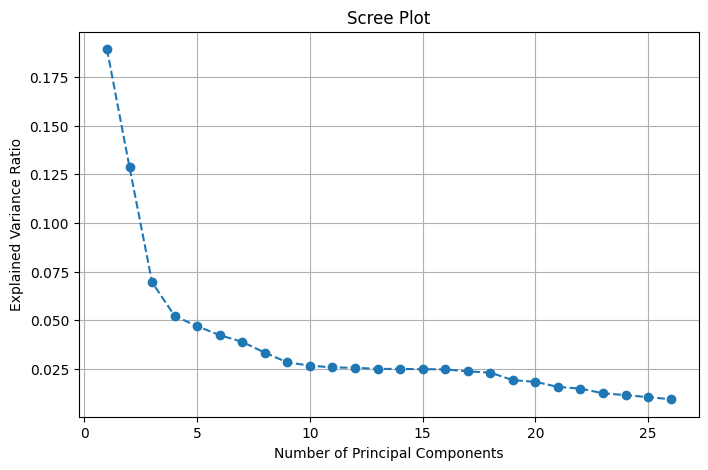

In [15]:
#엘보우 방법
import matplotlib.pyplot as plt

# 각 주성분의 분산 비율
explained_variance_ratio = pca.explained_variance_ratio_

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid()
plt.show()


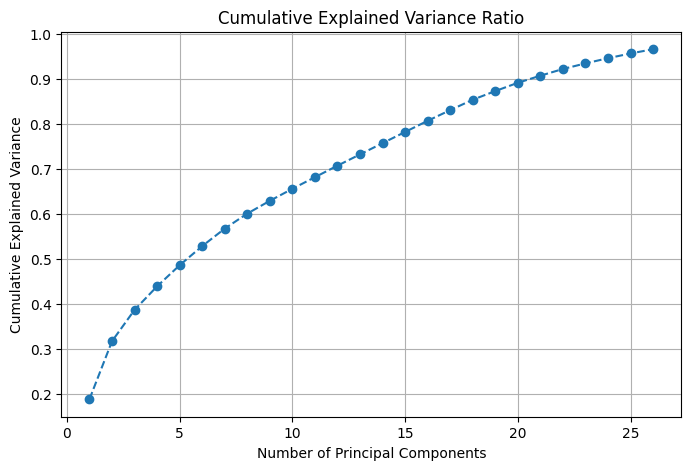

In [16]:
# 누적 분산 비율 계산
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# 누적 분산 비율 출력
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()


In [17]:
# X_pca를 DataFrame으로 변환
X_pca_df = pd.DataFrame(X_pca)

# `assign`으로 label 추가
df_merged = X_pca_df.assign(label=df['class'].values)

In [18]:
df = df_merged

In [19]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,-0.937416,-0.099287,-0.033490,0.114524,-0.112026,0.446328,-0.370811,0.123425,0.165005,0.209008,...,-0.213416,0.607659,-0.289704,-0.154749,0.252370,-1.401401,-0.419864,-0.131365,-1.031005,0
1,0.685951,0.530801,0.084341,-0.314059,0.079046,2.454923,-3.183684,0.747470,-0.687928,-0.280957,...,-0.348077,1.279437,0.372079,-1.344555,0.561106,-1.305773,-0.459898,-0.477740,0.243817,0
2,3.557238,-2.531658,0.044006,0.309697,-0.259197,-0.446973,-0.130156,0.014142,0.166662,0.091613,...,-0.034057,-0.207654,0.118251,-0.291461,0.043777,0.080835,0.102341,0.307538,0.231391,1
3,-2.613555,-0.501687,-0.070456,0.034864,-0.304282,-1.015089,0.093341,0.047633,0.012301,-0.235640,...,-0.022227,0.199033,-0.887815,-0.019916,-0.091845,0.909865,-0.331898,0.017550,-0.098237,0
4,-2.403517,-0.363544,-0.127620,-1.076496,0.106070,-0.662833,0.163658,-0.015152,-0.018131,-0.343138,...,0.016426,-0.411946,-0.088896,0.453858,-0.088159,-0.405434,0.550029,-0.137015,0.404394,0


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((133665, 27), (14852, 27))

In [21]:
X_train_normal = X_train[X_train['label'] == 0]
X_train_normal.shape

X_test_normal = X_test[X_test['label'] == 0]
X_test_normal.shape

(7720, 27)

In [22]:
y_train_normal = X_train_normal['label']
X_train_normal = X_train_normal.drop(labels='label',axis=1)

y_test_normal = X_test_normal['label']
X_test_normal = X_test_normal.drop(labels='label',axis=1)

In [23]:
y_test = X_test['label']
X_test = X_test.drop(labels='label', axis=1)

In [24]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=3aff78b4cd07ca129ae4d4e62f65b85a9e2f2700a83e4d542d7a25886d8bd7e4
  Stored in directory: /home/work/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [25]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=200, 
                    validation_split=0.1,  
                    batch_size=32).history  

2025-01-03 04:09:22.688564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0
2025-01-03 04:09:22.690729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 26)                52        ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 26)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 26)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2025-01-03 04:09:24.999852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-03 04:09:25.670366: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f99c2719f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-03 04:09:25.670413: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-03 04:09:25.670421: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2025-01-03 04:09:25.675619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-03 04:09:25.757146: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1950/1950 [==============================] - 15s 6ms/step - loss: 13.2395 - accuracy: 0.7085 - val_loss: 2.3333 - val_accuracy: 0.8112
Epoch 2/200
1950/1950 [==============================] - 11s 5ms/step - loss: 11.2143 - accuracy: 0.8083 - val_loss: 2.3747 - val_accuracy: 0.8255
Epoch 3/200
1950/1950 [==============================] - 11s 5ms/step - loss: 8.0086 - accuracy: 0.8275 - val_loss: 5.0731 - val_accuracy: 0.8359
Epoch 4/200
1950/1950 [==============================] - 11s 5ms/step - loss: 4.6531 - accuracy: 0.8308 - val_loss: 1.0976 - val_accuracy: 0.8724
Epoch 5/200
1950/1950 [==============================] - 11s 5ms/step - loss: 4.1126 - accuracy: 0.8471 - val_loss: 1.6640 - val_accuracy: 0.8809
Epoch 6/200
1950/1950 [==============================] - 11s 5ms/step - loss: 6.6012 - accuracy: 0.8464 - val_loss: 1.0721 - val_accuracy: 0.8641
Epoch 7/200
1950/1950 [==============================] - 10s 5ms/step - loss: 5.6537 - accuracy: 0.8739 - val_loss: 0.8570 - val_accur

Epoch 57/200
1950/1950 [==============================] - 11s 5ms/step - loss: 2.3266 - accuracy: 0.9236 - val_loss: 0.2305 - val_accuracy: 0.9400
Epoch 58/200
1950/1950 [==============================] - 11s 5ms/step - loss: 1.3204 - accuracy: 0.9216 - val_loss: 0.7851 - val_accuracy: 0.8996
Epoch 59/200
1950/1950 [==============================] - 11s 5ms/step - loss: 1.9966 - accuracy: 0.9126 - val_loss: 0.2593 - val_accuracy: 0.9226
Epoch 60/200
1950/1950 [==============================] - 10s 5ms/step - loss: 4.0258 - accuracy: 0.9169 - val_loss: 0.3824 - val_accuracy: 0.8738
Epoch 61/200
1950/1950 [==============================] - 11s 5ms/step - loss: 2.1504 - accuracy: 0.9198 - val_loss: 0.2599 - val_accuracy: 0.9378
Epoch 62/200
1950/1950 [==============================] - 11s 5ms/step - loss: 0.9783 - accuracy: 0.9306 - val_loss: 0.2420 - val_accuracy: 0.9264
Epoch 63/200
1950/1950 [==============================] - 11s 5ms/step - loss: 1.0047 - accuracy: 0.9263 - val_loss: 0

1950/1950 [==============================] - 10s 5ms/step - loss: 1.2920 - accuracy: 0.9204 - val_loss: 0.2256 - val_accuracy: 0.9451
Epoch 176/200
1950/1950 [==============================] - 10s 5ms/step - loss: 1.6377 - accuracy: 0.9375 - val_loss: 0.1675 - val_accuracy: 0.9579
Epoch 177/200
1950/1950 [==============================] - 10s 5ms/step - loss: 1.3649 - accuracy: 0.9335 - val_loss: 0.2831 - val_accuracy: 0.9390
Epoch 178/200
1950/1950 [==============================] - 10s 5ms/step - loss: 3.3128 - accuracy: 0.9407 - val_loss: 0.1821 - val_accuracy: 0.9524
Epoch 182/200
1950/1950 [==============================] - 10s 5ms/step - loss: 1.8735 - accuracy: 0.9442 - val_loss: 0.1723 - val_accuracy: 0.9570
Epoch 183/200
1950/1950 [==============================] - 10s 5ms/step - loss: 0.6173 - accuracy: 0.9428 - val_loss: 1.2717 - val_accuracy: 0.7828
Epoch 184/200
1950/1950 [==============================] - 10s 5ms/step - loss: 0.6270 - accuracy: 0.9396 - val_loss: 0.7021 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



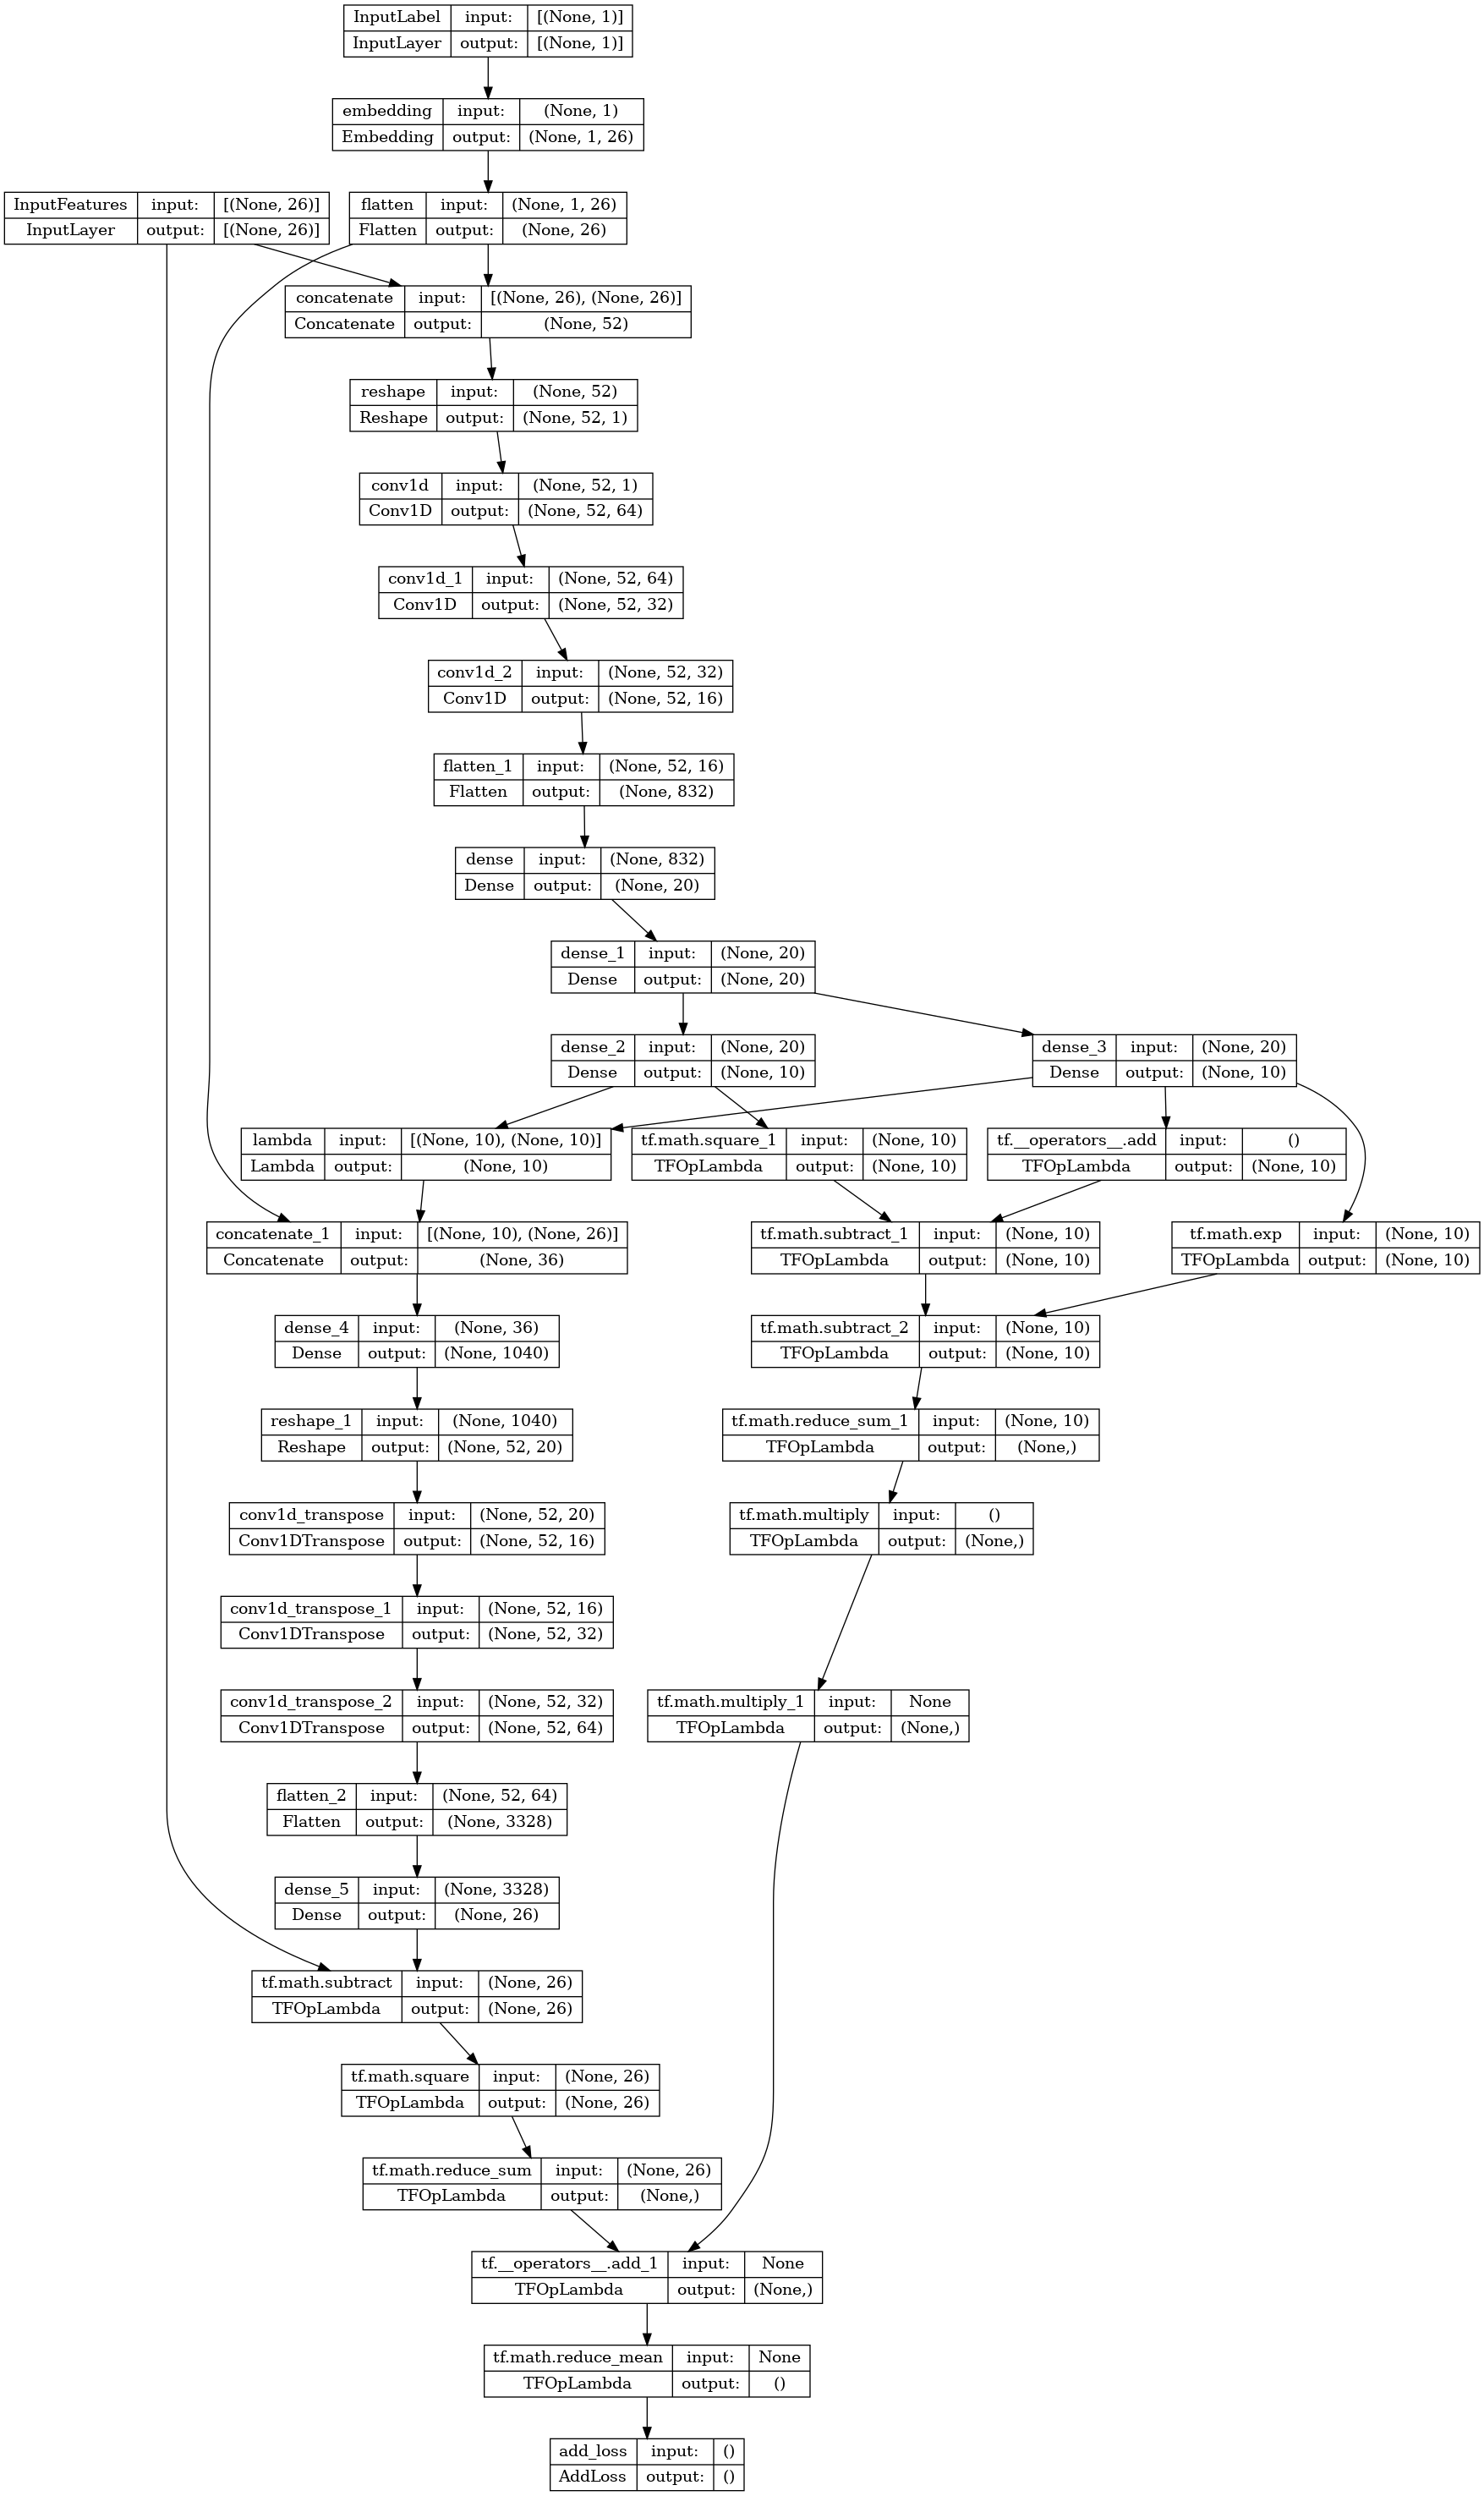

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

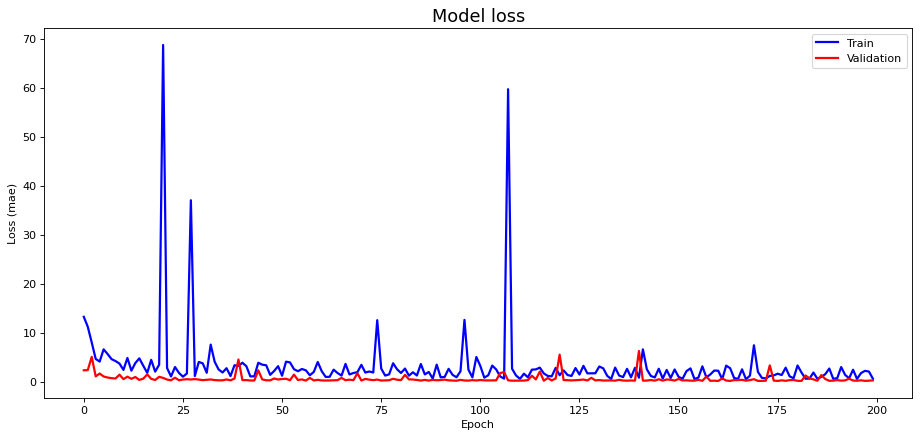

In [28]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [29]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [30]:
X_test.shape

(14852, 26)

In [31]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

465/465 [==============================] - 1s 2ms/step


In [32]:
error_df

,reconstruction_error,true_class
38166,0.001996,0
122124,0.000411,0
137236,0.000209,0
59637,0.000672,0
117914,1.153259,1
...,...,...
30563,1.482322,1
148505,0.000335,0
125705,1.563150,1
132943,0.001358,0


In [33]:
error_df['true_class'].value_counts()

0    7720
1    7132
Name: true_class, dtype: int64

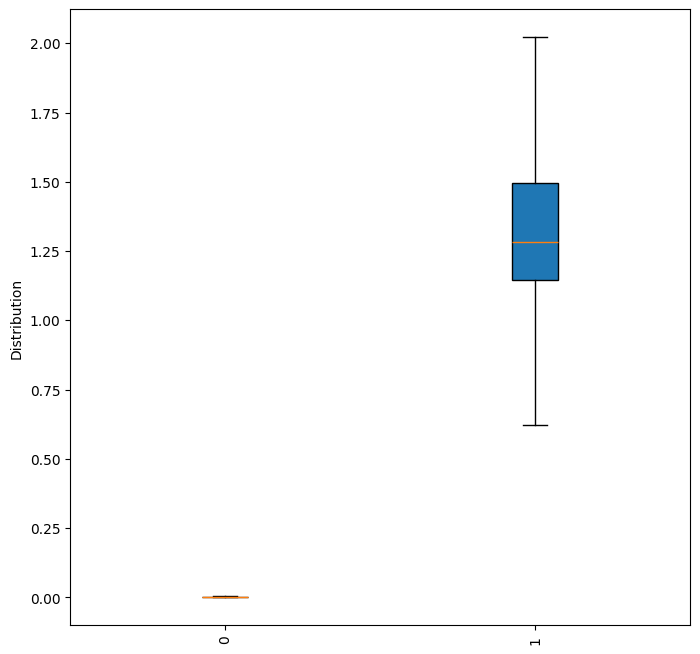

In [34]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


In [35]:
print(error_df)

        reconstruction_error  true_class
38166               0.001996           0
122124              0.000411           0
137236              0.000209           0
59637               0.000672           0
117914              1.153259           1
...                      ...         ...
30563               1.482322           1
148505              0.000335           0
125705              1.563150           1
132943              0.001358           0
49983               1.154252           1

[14852 rows x 2 columns]


In [36]:
print(error_df[(error_df['reconstruction_error'] >= 3) & (error_df['true_class'] == 0)].count())

reconstruction_error    12
true_class              12
dtype: int64


In [37]:
print(error_df[(error_df['reconstruction_error'] < 3) & (error_df['true_class'] == 1)].count())

reconstruction_error    6852
true_class              6852
dtype: int64


In [38]:
# 그래프 보고 threshold 결정
threshold = 0.4

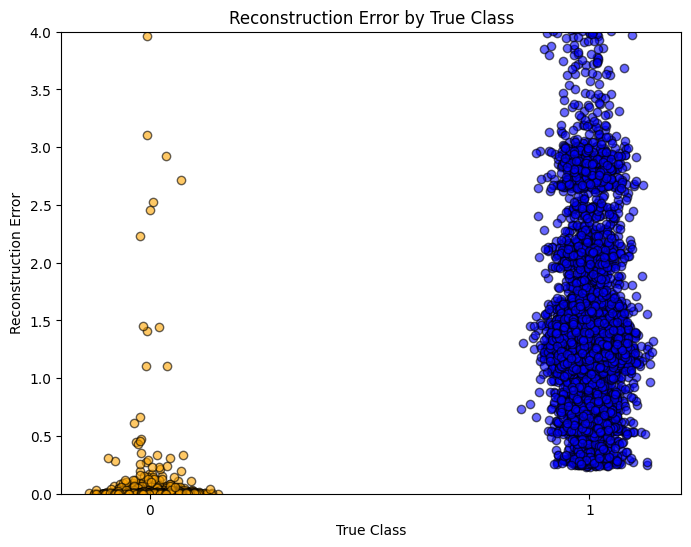

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 4)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


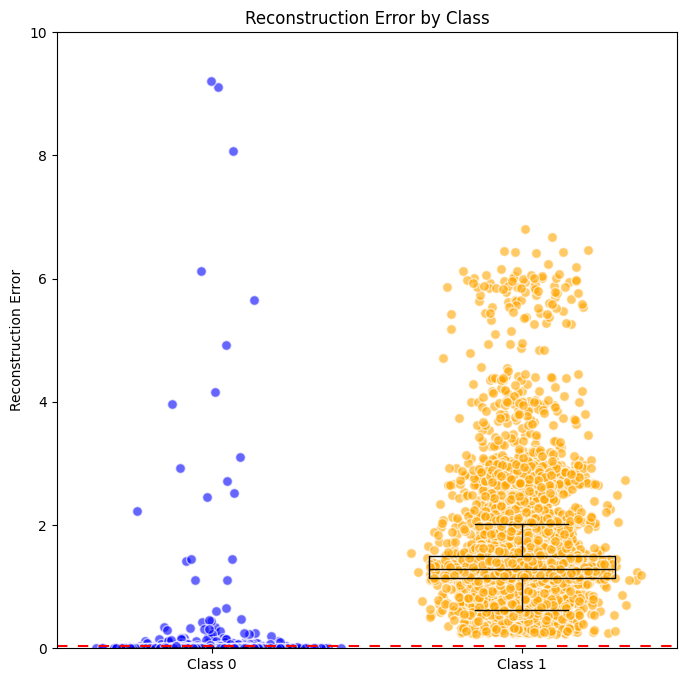

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=10)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


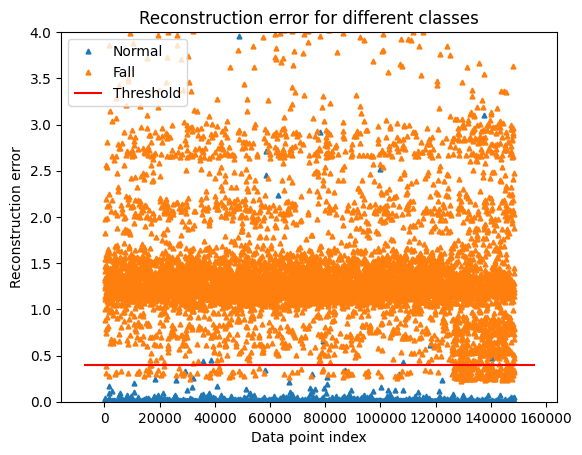

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Best threshold: 0.2
Best F1 score: 0.9971338692764767


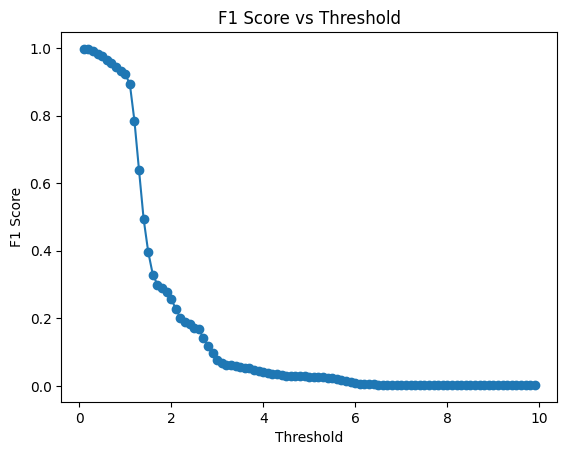

In [42]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0.1, 10, 0.1)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [50]:
# 그래프 보고 threshold 결정
threshold = 0.2

<Figure size 1200x1200 with 0 Axes>

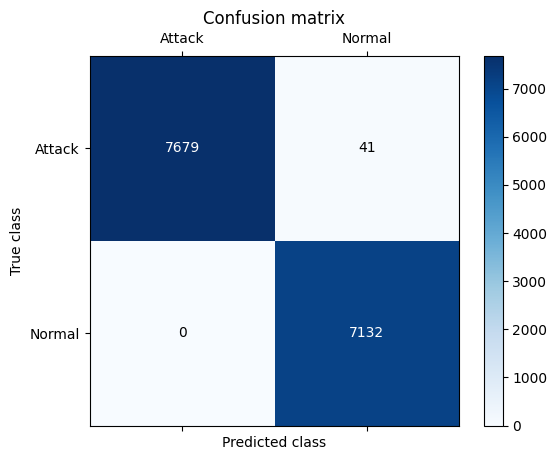

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [52]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9972394290331269
Precision : 0.9942841210093406
Recall : 1.0
F1 : 0.9971338692764767


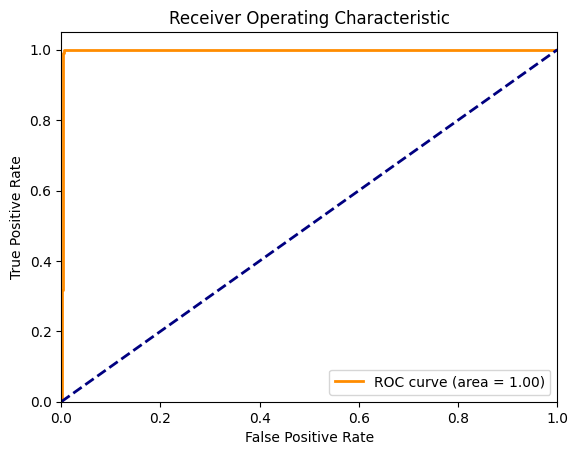

In [53]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


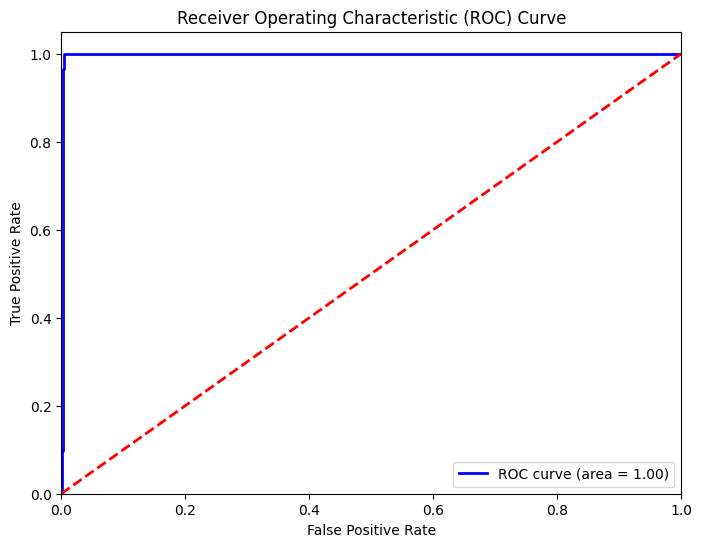

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [55]:
print(f"ROC Score : {roc_auc}")

ROC Score : 0.9974857353124936


In [56]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.9972394290331269
Precision: 0.9942841210093406
Recall: 1.0
F1 Score: 0.9971338692764767
